In [152]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import math

In [153]:
##########################################################################################################

def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

##########################################################################################################3

def fitusingscikitl (train_x, train_y):
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5))* gp.kernels.RBF(length_scale=1)
    kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([5,5], (1e-2, 1e2))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, \
        normalize_y=False)
    print("Start training ")
    model.fit(train_x, train_y)
    print("Done ")

    return model

##########################################################################################################


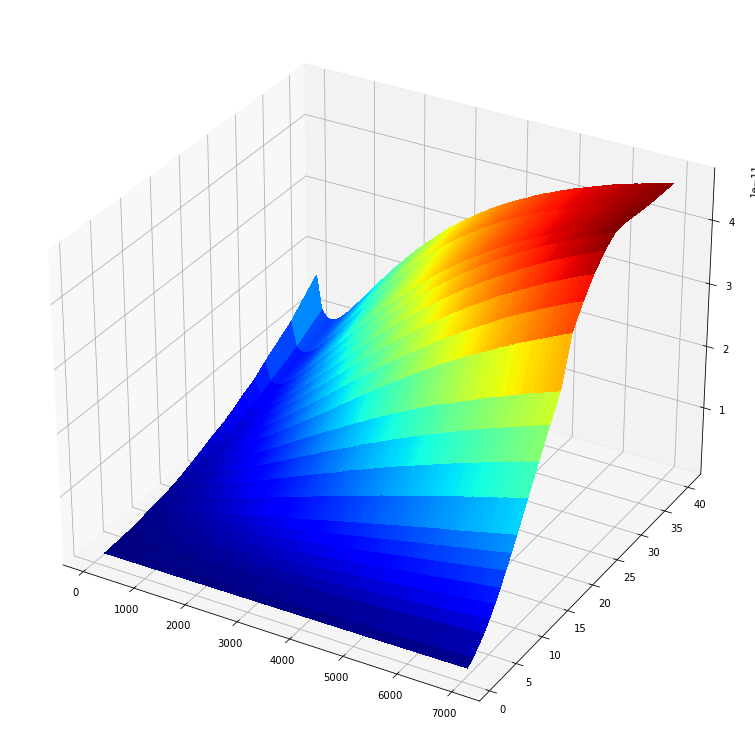

In [154]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

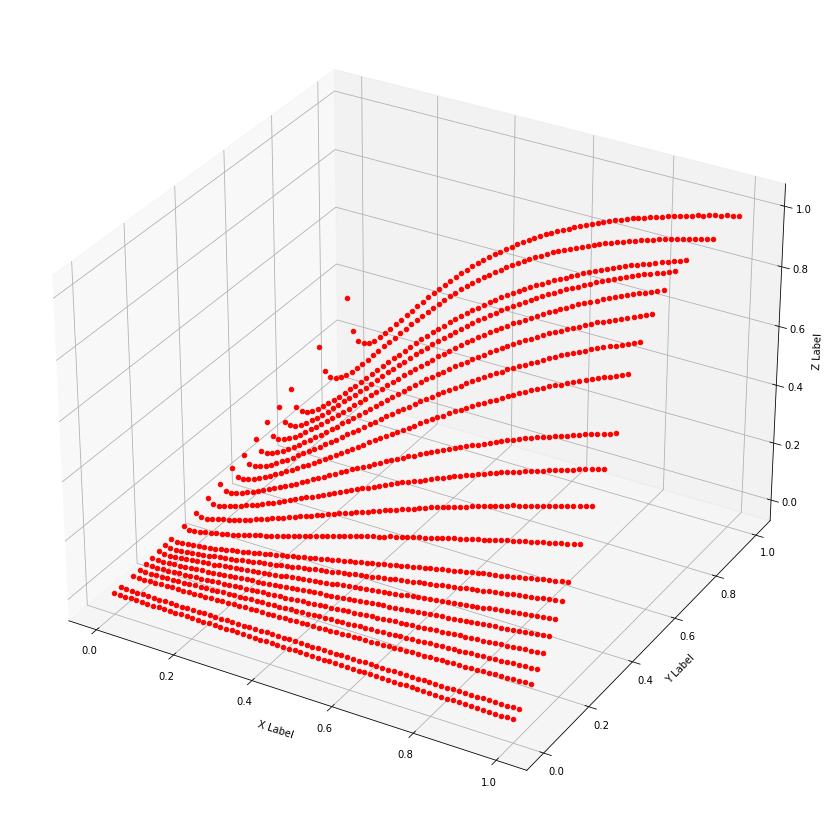

In [155]:
maxt = max(temp_values)
mint = min(temp_values)

minv = min(vib_values)
maxv = max(vib_values)

train_xy = []
train_z = []

maxz = float("-inf")
minz = float("+inf")

for tidx, t in enumerate(temp_values):
    for vidx, v in enumerate(vib_values):
        zval = df[t].values[vidx]

        if zval < minz:
            minz = zval
        elif zval > maxz:
            maxz = zval

for tidx, t in enumerate(temp_values):
    tnorm = (t - mint)/(maxt - mint)
    #print(t, " ", tnorm)

    for vidx, v in enumerate(vib_values):
        vnorm  = (v - minv)/(maxv - minv)
    
        train_xy.append([tnorm, vnorm])
        
        z = df[t].values[vidx]
        znorm = (z - minz)/(maxz - minz)
        train_z.append(znorm)

        #print("  %10.2f %10.7f ==> %10.7e %10.7f"%(v, vnorm, z, znorm ))

train_xy = np.asarray(train_xy)
train_z = np.asarray(train_z)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()

In [156]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 2, activation = 'linear', input_shape=[2]))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 128, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam", metrics='mse')
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 2)                 6         
                                                                 
 dense_147 (Dense)           (None, 64)                192       
                                                                 
 dense_148 (Dense)           (None, 64)                4160      
                                                                 
 dense_149 (Dense)           (None, 128)               8320      
                                                                 
 dense_150 (Dense)           (None, 1)                 129       
                                                                 
Total params: 12,807
Trainable params: 12,807
Non-trainable params: 0
_________________________________________________________________


In [157]:

from sklearn.model_selection import train_test_split

usevalidation = False
history = None
nepochs = 100

if usevalidation:
    X_train, X_val, y_train, y_val \
            = train_test_split(train_xy, train_z, \
            test_size=0.33, random_state=42)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nepochs, verbose=1)
else:
    history = model.fit(train_xy, train_z, epochs=nepochs, verbose=1)

Epoch 1/100
46/46 [==============================] - 0s 992us/step - loss: 0.0440 - mse: 0.0440
Epoch 2/100
46/46 [==============================] - 0s 1ms/step - loss: 0.0061 - mse: 0.0061
Epoch 3/100
46/46 [==============================] - 0s 1ms/step - loss: 0.0017 - mse: 0.0017
Epoch 4/100
46/46 [==============================] - 0s 995us/step - loss: 0.0011 - mse: 0.0011
Epoch 5/100
46/46 [==============================] - 0s 1ms/step - loss: 8.2439e-04 - mse: 8.2439e-04
Epoch 6/100
46/46 [==============================] - 0s 1ms/step - loss: 7.1227e-04 - mse: 7.1227e-04
Epoch 7/100
46/46 [==============================] - 0s 1ms/step - loss: 7.4641e-04 - mse: 7.4641e-04
Epoch 8/100
46/46 [==============================] - 0s 1ms/step - loss: 6.2272e-04 - mse: 6.2272e-04
Epoch 9/100
46/46 [==============================] - 0s 1ms/step - loss: 4.8749e-04 - mse: 4.8749e-04
Epoch 10/100
46/46 [==============================] - 0s 1ms/step - loss: 4.6492e-04 - mse: 4.6492e-04
Epoch 1

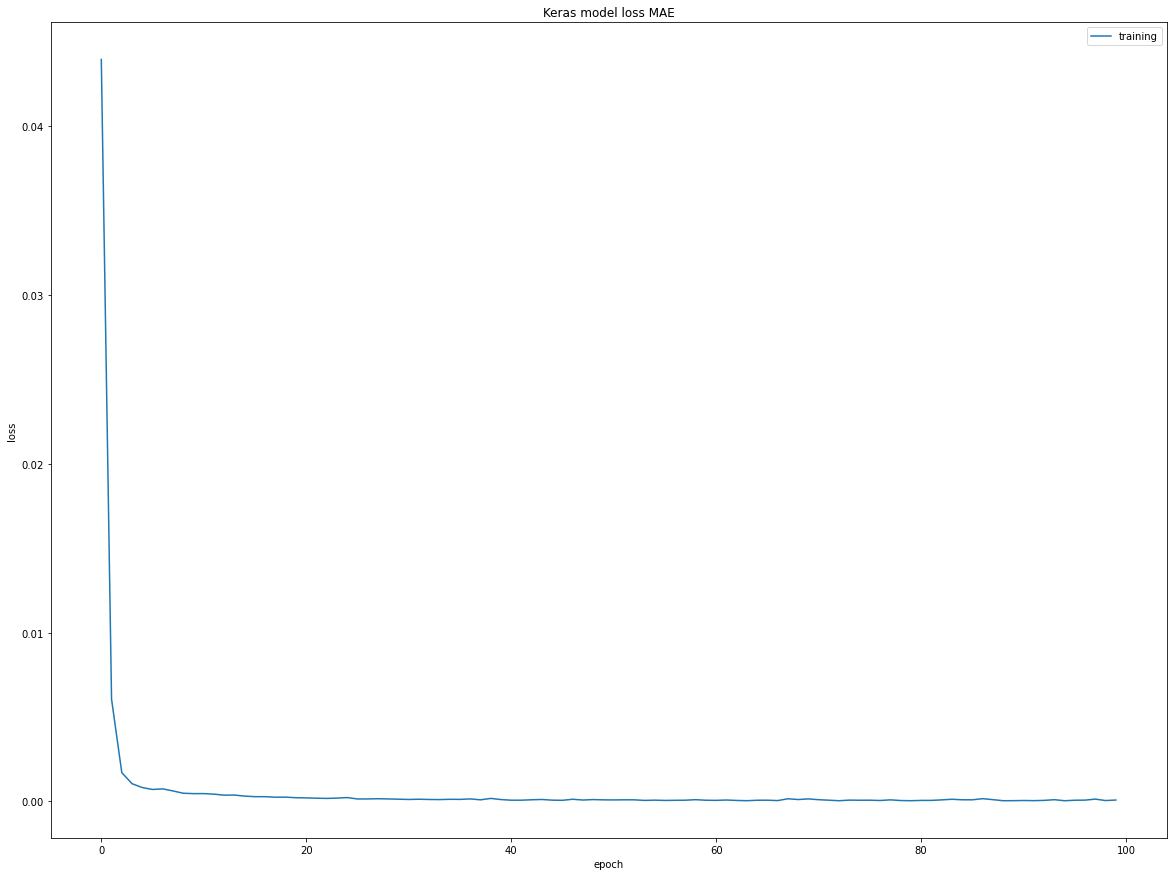

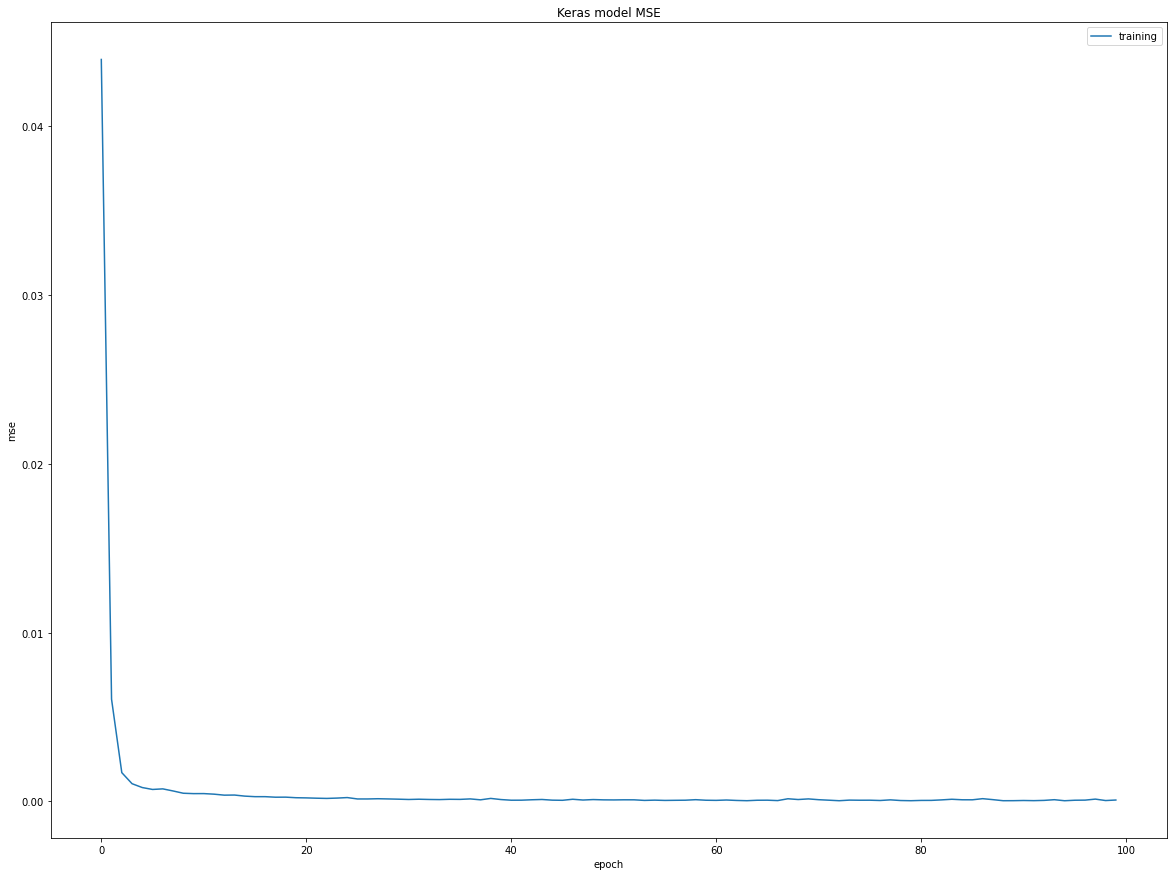

In [158]:
plt.title('Keras model loss MAE')
plt.plot(history.history['loss'])
if usevalidation:
    plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.gcf().set_size_inches(20, 15)

plt.show()

plt.clf()
plt.title('Keras model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.plot(history.history['mse'])
if usevalidation:
    plt.plot(history.history['val_mse'])
plt.legend(['training', 'validation'], loc='upper right')
plt.gcf().set_size_inches(20, 15)

plt.show()

In [159]:
# Compute the output 
test_xy = []

test_xy = train_xy

z_pred = model.predict(train_xy)

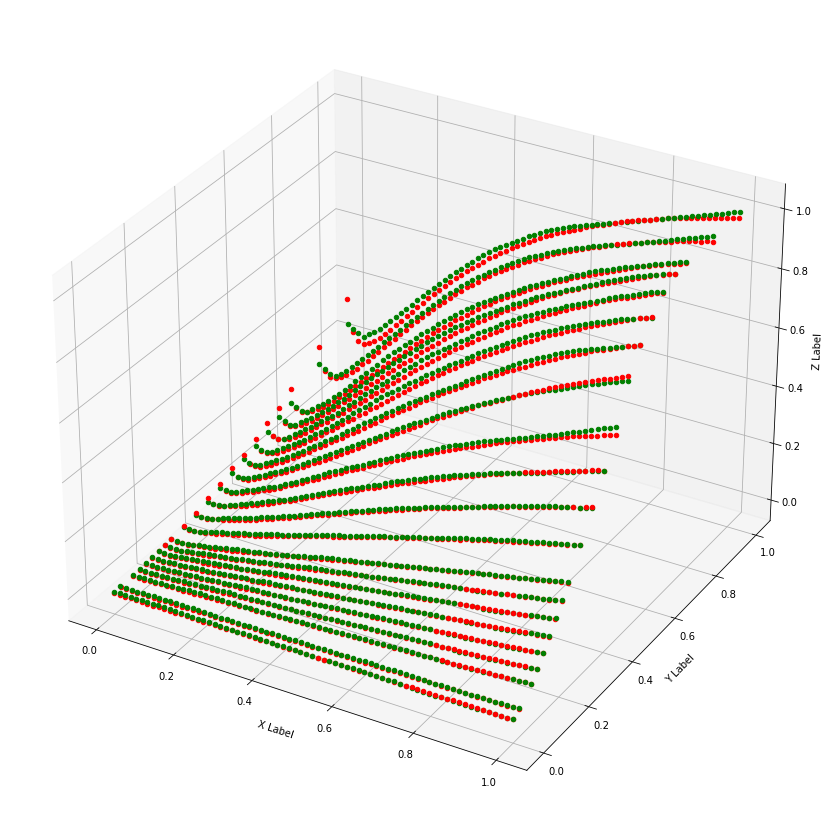

In [160]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    ax.scatter(x, y, z, marker="o", color="r")

for i in range(train_z.shape[0]):
    x = test_xy[i,0]
    y = test_xy[i,1]
    z = z_pred[i]
    ax.scatter(x, y, z, marker="o", color="g")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.gcf().set_size_inches(20, 15)

plt.show()

In [161]:
for i in range(train_z.shape[0]):
    x = train_xy[i,0]
    y = train_xy[i,1]
    z = train_z[i]
    zpred = z_pred[i]

    diff = 100.0*(math.fabs(zpred-z) / (math.fabs(zpred+z)/2))

    if diff > 1.0e-2:
        print("%6.2f, %10.7e , %10.7e"%(diff, z, zpred))

194.69, 7.2209527e-05 , 5.3643826e-03
153.22, 8.8987622e-04 , 6.7197811e-03
 79.23, 3.5297716e-03 , 8.1608873e-03
 43.33, 5.1226288e-03 , 7.9562496e-03
 22.97, 7.6712003e-03 , 9.6616615e-03
 21.73, 1.0432153e-02 , 1.2975836e-02
  6.34, 1.4318724e-02 , 1.5256757e-02
  1.58, 1.7525677e-02 , 1.7251430e-02
  7.73, 2.1560915e-02 , 1.9956505e-02
 10.88, 2.8994249e-02 , 2.6001351e-02
 19.96, 3.9613297e-02 , 3.2424048e-02
 25.95, 5.4692345e-02 , 4.2131804e-02
 23.04, 6.9983774e-02 , 5.5524260e-02
 21.04, 8.8885680e-02 , 7.1962871e-02
 16.57, 1.0162854e-01 , 8.6080700e-02
 20.16, 1.2095520e-01 , 9.8802224e-02
 24.60, 1.4516663e-01 , 1.1336157e-01
 22.13, 1.6406854e-01 , 1.3138017e-01
 28.16, 1.9528854e-01 , 1.4707863e-01
 26.14, 2.6091426e-01 , 2.0059548e-01
 29.88, 3.5223807e-01 , 2.6068068e-01
200.00, 0.0000000e+00 , 5.3392705e-03
161.34, 6.4563812e-04 , 6.0346331e-03
 91.53, 2.7652001e-03 , 7.4320938e-03
 67.56, 4.1244383e-03 , 8.3327312e-03
 46.20, 6.0571050e-03 , 9.6960608e-03
 43.46, 8.05